# Examine changes in viable habitat

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from itertools import product
import json
import yaml
import intake
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import funnel
import data_collections as dc
import operators as ops
import util

import metabolic as mi

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
curator = util.curator_local_assets()
cat = curator.open_catalog()  
ds_ts = cat['trait-space'].to_dask().load()
trait_spc_wgt = ds_ts.trait_spc_wgt

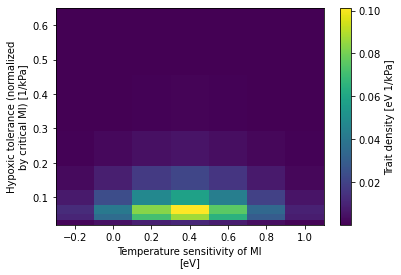

In [4]:
trait_spc_wgt.plot();

In [5]:
dEodT_bar = mi.dEodT_bar
dEodT_bar

0.022

In [6]:
catalog_json_file = funnel.to_intake_esm(agg_member_id=True)

sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids[1:],
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog

,unique
experiment,2
component,1
stream,1
member_id,31
variable,7
name,1
path,390


In [7]:
catalog.search(experiment='20C', variable=['pO2', 'TEMP'], member_id=10).df

,experiment,component,stream,member_id,variable,name,path
0,20C,ocn,pop.h,10,TEMP,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...
1,20C,ocn,pop.h,10,pO2,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...


In [8]:
cache_dir = '/glade/scratch/mclong/ocean-metabolism/funnel-cache'

def _gen_cache_file_name(experiment, component, stream, member_id, variable):
    return f'{cache_dir}/glade-cesm1-le.{experiment}.{component}.{stream}.{int(member_id):03d}.{variable}.drift-corrected.zarr'


def _make_cache(experiment, component, stream, member_id, variable):
    """
    Manually generate funnel catalog entry
    
    I.e.:
    asset: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.101.TEMP.drift-corrected.zarr
    esm_collection: data/catalogs/glade-cesm1-le.json
    key: 20C.ocn.pop.h.101
    name: drift-corrected
    operator_kwargs:
    - {}
    - {}
    - {}
    operators:
    - compute_time
    - sel_time_slice
    - compute_drift_correction
    preprocess: _preprocess_pop_h_upper_1km
    variable: TEMP
    """
    
    cache_id_dict = dict(
        asset=_gen_cache_file_name(experiment, component, stream, member_id, variable),
        esm_collection='data/catalogs/glade-cesm1-le.json',        
        key=f'{experiment}.{component}.{stream}.{member_id}',
        name='drift-corrected',
        operator_kwargs=[{}, {}, {}],
        operators=['compute_time', 'sel_time_slice', 'compute_drift_correction'],
        preprocess='_preprocess_pop_h_upper_1km',
        variable=variable,
    )
    cache_id_file = f'data/funnel-catalog/glade-cesm1-le.{experiment}.{component}.{stream}.{int(member_id):03d}.{variable}.drift-corrected.yml'
    with open(cache_id_file, 'w') as fid:
        yaml.dump(cache_id_dict, fid)    
        

In [9]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='100GB')
    cluster.scale(34)
client    

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.55:38893,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [16]:
# refresh catalog
catalog = funnel.to_intake_esm(agg_member_id=False).search(**sub_spec)
experiment_list = sorted(catalog.unique('experiment')['experiment']['values'])
member_id_list = sorted(catalog.unique('member_id')['member_id']['values'])

In [25]:
clobber = True

do_apply_ufunc = False

stream = 'pop.h'
component = 'ocn'
    
variable = 'Phi_prime'
variable_std = f'{variable}_std'


# compute Phi over trait space
for experiment, member_id in product(experiment_list, member_id_list):
    # check for existing cache file        

    asset = _gen_cache_file_name(experiment, component, stream, member_id, variable)

    if clobber and os.path.exists(asset):
        print(f'removing: {asset}')
        shutil.rmtree(asset)

    if os.path.exists(asset):
        print(f'exists: {asset}')
        continue    

    cat = catalog.search(
        experiment=experiment, 
        member_id=member_id,         
        stream=stream, 
        component=component,
        variable=['TEMP', 'pO2'],
    )

    dset = cat.to_dataset_dict()
    assert len(dset.keys()) == 1    
    _, ds = dset.popitem()
    
    Phi = xr.full_like(trait_spc_wgt * ds.pO2, fill_value=0.0)
    Phi.name = variable
    Phi.attrs['long_name'] = '$\Phi^\prime$'
    Phi.attrs['units'] = ''
    Phi.encoding['dtype'] = np.float32
    
    #Phi_std = xr.full_like(trait_spc_wgt * ds.pO2, fill_value=0.0)
    #Phi_std.name = variable_std
    #Phi_std.attrs['long_name'] = 'Std dev. $\Phi$'
    #Phi_std.attrs['units'] = ''
    #Phi_std.encoding['dtype'] = np.float32
    
    dso = ds[['TAREA', 'KMT', 'TLONG', 'TLAT', 'KMT', 'z_t', 'dz']]
    dso['Eo'] = trait_spc_wgt.Eo
    dso['Ac'] = trait_spc_wgt.Ac
    
    print(f'computing: {asset}')
    da_list_outer = []
    for i, Ac in enumerate(trait_spc_wgt.Ac.values):
        
        da_list_inner = []        
        for j, Eo in enumerate(trait_spc_wgt.Eo.values):
        
            if do_apply_ufunc:
                da_list_inner.append(xr.apply_ufunc(
                    mi.Phi, 
                    ds.pO2, ds.TEMP, 
                    kwargs=dict(Ac=Ac, Eo=Eo, dEodT=dEodT_bar),
                    dask='parallelized',
                ))
            else:            
                da_list_inner.append(mi.Phi(ds.pO2, ds.TEMP, Ac, Eo, dEodT=dEodT_bar))
        
        da_list_outer.append(xr.concat(da_list_inner, dim=trait_spc_wgt.Eo))

    print(f'writing: {asset}')    
    dso[variable] = xr.concat(da_list_outer, dim=trait_spc_wgt.Ac)
    
    dso.to_zarr(asset, mode='w', consolidated=True)    
    _make_cache(experiment, component, stream, member_id, variable)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.016.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.017.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.018.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.019.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.020.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.020.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.021.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.021.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.022.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.022.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.023.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.023.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.024.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.024.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.025.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.025.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.026.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.026.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.027.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.027.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.028.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.028.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.029.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.029.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.030.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.030.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.031.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.031.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.032.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.032.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.034.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.034.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.035.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.035.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.101.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.101.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.102.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.102.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.103.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.103.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.104.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.104.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.105.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.105.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.009.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.009.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.010.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.010.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.011.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.011.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.012.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.012.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.013.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.013.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.014.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.014.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.015.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.015.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.016.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.016.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.017.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.017.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.018.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.018.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.019.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.019.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.020.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.020.Phi_prime.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.021.Phi_prime.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.021.Phi_prime.drift-corrected.zarr


KilledWorker: ("('open_dataset-add-add-303e2cebe8dd31f8628333b8b652f814', 45, 3, 0, 0)", <WorkerState 'tcp://10.12.206.35:41682', name: PBSCluster-23, status: closed, memory: 0, processing: 180>)

In [19]:
Phi_avg

<xarray.DataArray 'Phi_prime' (Ac: 8, Eo: 7, member_id: 31, time: 1032, z_t: 40, nlat: 384, nlon: 320)>
dask.array<setitem, shape=(8, 7, 31, 1032, 40, 384, 320), dtype=float64, chunksize=(8, 7, 1, 12, 10, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * Ac         (Ac) float64 0.0258 0.0399 0.0619 0.0959 ... 0.2303 0.3568 0.5528
  * Eo         (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
  * member_id  (member_id) int64 9 10 11 12 13 14 15 ... 35 101 102 103 104 105
    KMT        (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA      (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    TLAT       (member_id, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TLONG      (member_id, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG      (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    dz         (z_t) float32 1e+03 1e+03 1e+03 ... 8.521e+03 9.844e+03 1.133e+04
  * time       (time) object 1920-01-17 00:29:59.999993 ... 2005-12-16 12:00:00
  * z_t        (z_t) float32 500.0 1.5e+03 2.5e+03 ... 8.788e+04 9.847e+04
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  $\Phi$
    units:

In [ ]:
del client
del cluster